In [1]:
!pip install pyspark

In [2]:
!pip install python-dotenv

In [3]:
from pyspark.sql import SparkSession
from dotenv import load_dotenv
import os
from pyspark.sql.functions import explode, col, to_timestamp, substring
from pyspark.sql.types import StructType, StructField, StringType, LongType, BooleanType, ArrayType

In [4]:
from google.colab import userdata


storage_account_name = userdata.get("AZURE_ACCOUNT_NAME")
storage_account_key = userdata.get("AZURE_STORAGE_KEY")

storage_container_name = "kaggle-datasets"
parquet_blob_name = "github-dataset-full.parquet"



In [5]:
# Creating Spark session
spark = SparkSession.builder \
    .appName("Read Parquet from Azure Blob Storage") \
    .config(f"spark.hadoop.fs.azure.account.key.{storage_account_name}.blob.core.windows.net", storage_account_key) \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.2,com.microsoft.azure:azure-storage:8.6.6") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

# Remove garbage error texts
spark.sparkContext.setLogLevel("ERROR")

In [6]:
spark.conf.set(
    f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net",storage_account_key)


# Set path to parquet file for access
parquet_path = f"wasbs://{storage_container_name}@{storage_account_name}.blob.core.windows.net/{parquet_blob_name}"


In [10]:
users_df = spark.read.parquet(
    "wasbs://kaggle-datasets@matthewleffler1.blob.core.windows.net/clean_data/non_list_data"
)

repo_list_df = spark.read.parquet(
    "wasbs://kaggle-datasets@matthewleffler1.blob.core.windows.net/clean_data/repo_list_data"
)

In [16]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, coalesce, lit


# SQL: License Trend by Language
from pyspark.sql.functions import col, count, sum

license_trend_df = repo_list_df \
    .filter((col("repo_license").isNotNull()) & (col("repo_license") != "")) \
    .groupBy("repo_license", "repo_language") \
    .agg(
        count("*").alias("repo_count"),
        sum(col("repo_stargazers_count").cast("int")).alias("total_stars")
    ) \
    .orderBy(col("repo_count").desc())



In [17]:
license_trend_df.show(20, truncate=False)

+------------------+-------------+----------+-----------+
|repo_license      |repo_language|repo_count|total_stars|
+------------------+-------------+----------+-----------+
|MIT License       |JavaScript   |777839    |2465972    |
|Apache License 2.0|Java         |405675    |866020     |
|Other             |JavaScript   |309784    |777816     |
|MIT License       |Python       |235170    |501285     |
|MIT License       |NULL         |227127    |206436     |
|Other             |Ruby         |172011    |144223     |
|Other             |Python       |170669    |435846     |
|MIT License       |Ruby         |152433    |442858     |
|MIT License       |PHP          |148780    |452305     |
|MIT License       |Java         |142489    |248926     |
|Other             |C            |133149    |323886     |
|Other             |Java         |131456    |263525     |
|Apache License 2.0|JavaScript   |127627    |392241     |
|MIT License       |Objective-C  |121995    |444106     |
|MIT License  

In [18]:
license_trend_df.orderBy("total_stars", ascending=False).show(20, truncate=False)

+------------------+-------------+----------+-----------+
|repo_license      |repo_language|repo_count|total_stars|
+------------------+-------------+----------+-----------+
|MIT License       |JavaScript   |777839    |2465972    |
|Apache License 2.0|Java         |405675    |866020     |
|Other             |JavaScript   |309784    |777816     |
|MIT License       |Python       |235170    |501285     |
|MIT License       |PHP          |148780    |452305     |
|MIT License       |Objective-C  |121995    |444106     |
|MIT License       |Ruby         |152433    |442858     |
|Other             |Python       |170669    |435846     |
|Other             |C++          |118859    |416420     |
|Apache License 2.0|JavaScript   |127627    |392241     |
|MIT License       |Swift        |68411     |354713     |
|Apache License 2.0|Go           |57371     |345800     |
|Other             |C            |133149    |323886     |
|MIT License       |Go           |63627     |302684     |
|Other        

In [19]:
# Convert Spark DataFrame to Pandas for plotting
license_trend_pd = license_trend_df.toPandas()

In [27]:
top_stars_trend = license_trend_pd.sort_values(by="total_stars", ascending=False).head(10)

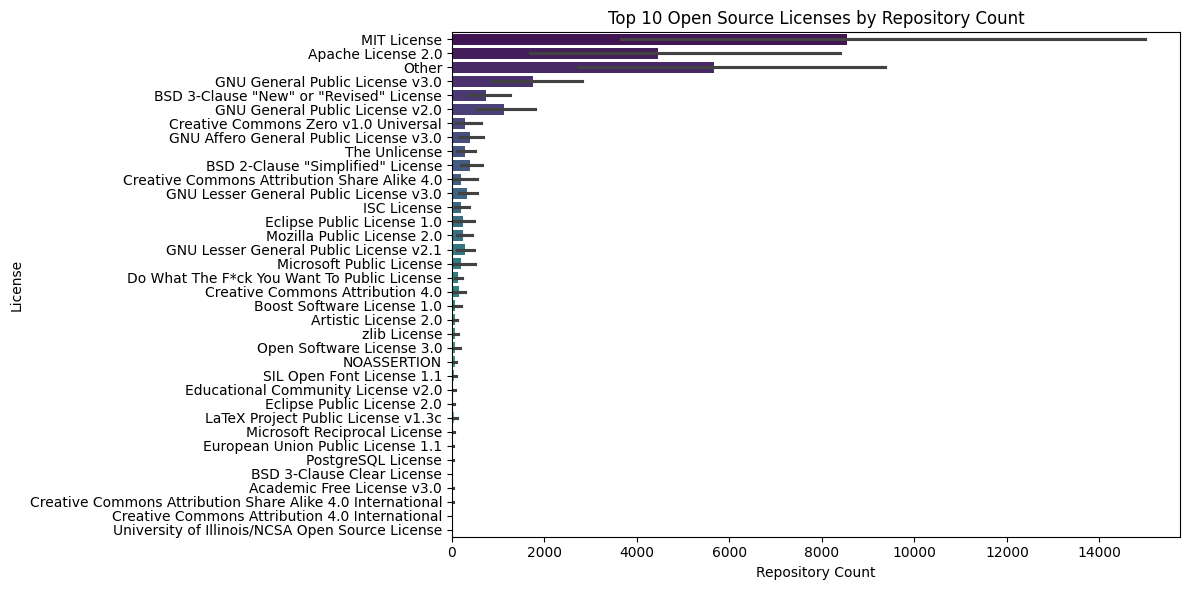

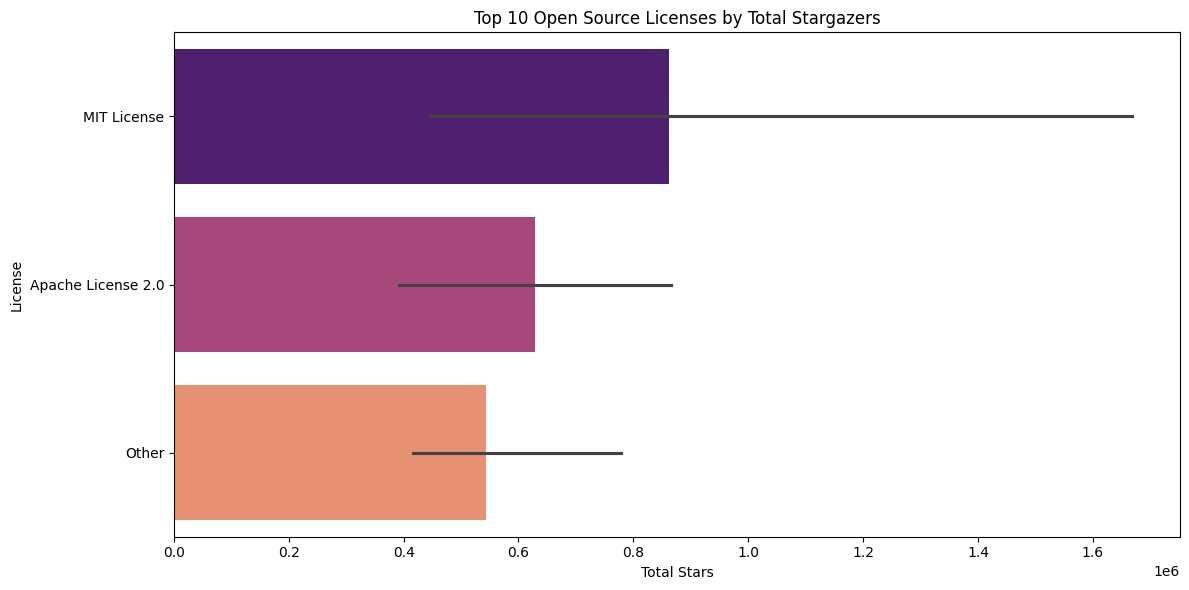

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 licenses by repo count
plt.figure(figsize=(12, 6))
sns.barplot(
    x="repo_count",
    y="repo_license",
    data=license_trend_pd,
    hue="repo_license",         # set hue to y-axis
    palette="viridis",
    dodge=False,
    legend=False                # hide legend
)
plt.title("Top 10 Open Source Licenses by Repository Count")
plt.xlabel("Repository Count")
plt.ylabel("License")
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 6))
sns.barplot(
    x="total_stars",
    y="repo_license",
    data=top_stars_trend,
    hue="repo_license",         # set hue to y-axis
    palette="magma",
    dodge=False,
    legend=False                # hide legend
)
plt.title("Top 10 Open Source Licenses by Total Stargazers")
plt.xlabel("Total Stars")
plt.ylabel("License")
plt.tight_layout()
plt.show()

In [33]:
# Save to new Parquet file
license_trend_df.write.mode("overwrite").parquet(
    "wasbs://kaggle-datasets@matthewleffler1.blob.core.windows.net/analytics/Top_license_trend"
)

In [35]:
license_trend_df_source = spark.read.parquet(
    "wasbs://kaggle-datasets@matthewleffler1.blob.core.windows.net/analytics/Top_license_trend"
)

In [36]:
license_trend_df_source.show()

+------------------+-------------+----------+-----------+
|      repo_license|repo_language|repo_count|total_stars|
+------------------+-------------+----------+-----------+
|       MIT License|   JavaScript|    777839|    2465972|
|Apache License 2.0|         Java|    405675|     866020|
|             Other|   JavaScript|    309784|     777816|
|       MIT License|       Python|    235170|     501285|
|       MIT License|         NULL|    227127|     206436|
|             Other|         Ruby|    172011|     144223|
|             Other|       Python|    170669|     435846|
|       MIT License|         Ruby|    152433|     442858|
|       MIT License|          PHP|    148780|     452305|
|       MIT License|         Java|    142489|     248926|
|             Other|            C|    133149|     323886|
|             Other|         Java|    131456|     263525|
|Apache License 2.0|   JavaScript|    127627|     392241|
|       MIT License|  Objective-C|    121995|     444106|
|       MIT Li